# Data Loading and Extraction

In [1]:
import os
import zipfile
from glob import glob
from itertools import cycle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from matplotlib.ticker import FuncFormatter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/dataset/test.zip'
extract_root = '/content/dataset/test_extract'

os.makedirs(extract_root, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_root)

def find_folder(root, name):
    for dirpath, dirnames, filenames in os.walk(root):
        if os.path.basename(dirpath) == name:
            return dirpath
    return None

images_dir = find_folder(extract_root, 'images')
labels_dir = find_folder(extract_root, 'labels')

if images_dir is None or labels_dir is None:
    raise FileNotFoundError("Could not find 'images' or 'labels' folder after extraction.")

print(f"Images folder: {images_dir}")
print(f"Labels folder: {labels_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Images folder: /content/dataset/test_extract/test/images
Labels folder: /content/dataset/test_extract/test/labels


# Data Loading and Preprocessing

In [6]:
import glob
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import os

# training order
class_order = [
    'annular',
    'bubbly',
    'churn',
    'slug',
    'transition_bubbly-slug',
    'transition_churn-annular',
    'transition_slug-churn'
]

IMG_HEIGHT, IMG_WIDTH = 598, 96
IMG_CHANNELS = 3

def resize_and_pad(image, target_width, target_height):
    h, w = image.shape[:2]
    scale = min(target_width / w, target_height / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized_img = cv2.resize(image, (new_w, new_h))

    pad_w = (target_width - new_w) // 2
    pad_h = (target_height - new_h) // 2

    padded_img = np.zeros((target_height, target_width, 3), dtype=np.float32)
    padded_img[pad_h:pad_h+new_h, pad_w:pad_w+new_w, :] = resized_img
    return padded_img

images_path = sorted(glob.glob(os.path.join(images_dir, "*.png")))
labels_path = sorted(glob.glob(os.path.join(labels_dir, "*.txt")))

X_test = []
y_test = []

for img_path, lbl_path in zip(images_path, labels_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Failed to load image {img_path}, skipping.")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = resize_and_pad(img, IMG_WIDTH, IMG_HEIGHT)
    img = img / 255.0
    X_test.append(img)

    with open(lbl_path, "r") as f:
        first_line = f.readline().strip()
        try:
            class_id = int(first_line.split()[0])
            if class_id not in range(len(class_order)):
                print(f"Warning: Invalid class_id {class_id} in {lbl_path}, skipping")
                continue
            y_test.append(class_id)
        except (IndexError, ValueError) as e:
            print(f"Error reading label {lbl_path}: {e}, skipping")
            continue

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)
y_test_categorical = torch.tensor(np.eye(len(class_order))[y_test], dtype=torch.float32)

print(f"Loaded {len(X_test)} test images and {len(y_test)} labels")

class TestDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # transpose to (C, H, W)
        return torch.tensor(self.images[idx].transpose(2, 0, 1), dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

test_dataset = TestDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Loaded 415 test images and 415 labels


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Definition and Loading

In [7]:
display_labels = {
    'annular': 'Annular',
    'bubbly': 'Bubbly',
    'churn': 'Churn',
    'slug': 'Slug',
    'transition_bubbly-slug': 'Bub-Slug',
    'transition_churn-annular': 'Churn-Ann',
    'transition_slug-churn': 'Slug-Churn'
}

class_colors = {
    'annular': (0, 255, 0),
    'bubbly': (255, 255, 0),
    'churn': (0, 165, 255),
    'slug': (255, 0, 255),
    'transition_bubbly-slug': (128, 255, 128),
    'transition_churn-annular': (128, 128, 255),
    'transition_slug-churn': (255, 128, 128)
}

# PINNFlowClassifier
class PINNFlowClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PINNFlowClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(32 * (598 // 4) * (96 // 4), 128)
        self.dropout2 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.lambda_phys = 0.1

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def physics_loss(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        grad_x = torch.pow(x[:, :, :-1, :] - x[:, :, 1:, :], 2).mean() / (x.mean() + 1e-8)
        grad_y = torch.pow(x[:, :, :, :-1] - x[:, :, :, 1:], 2).mean() / (x.mean() + 1e-8)
        return self.lambda_phys * 100 * (grad_x + grad_y)

print(f"Using device: {device}")

model_path = '/content/drive/MyDrive/model/pinn_best_flow_classifier.pt'
model = PINNFlowClassifier(num_classes=len(class_order)).to(device)
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print(f"Loaded model weights from {model_path}")

y_pred_probs = []
y_pred_classes = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        y_pred_probs.append(probs)
        y_pred_classes.append(torch.argmax(outputs, dim=1).cpu().numpy())

y_pred_probs = np.concatenate(y_pred_probs, axis=0)
y_pred_classes = np.concatenate(y_pred_classes, axis=0)

print(f"Predictions shape: {y_pred_probs.shape}")
print(f"Sample predicted classes (indices): {y_pred_classes[:10]}")

# Map indices directly to class names and display labels
predicted_labels = [class_order[i] for i in y_pred_classes]
predicted_display_names = [display_labels[label] for label in predicted_labels]

print(f"Sample predicted classes (display names): {predicted_display_names[:10]}")

Using device: cuda
Loaded model weights from /content/drive/MyDrive/model/pinn_best_flow_classifier.pt
Predictions shape: (415, 7)
Sample predicted classes (indices): [4 3 3 1 1 1 3 3 1 1]
Sample predicted classes (display names): ['Bub-Slug', 'Slug', 'Slug', 'Bubbly', 'Bubbly', 'Bubbly', 'Slug', 'Slug', 'Bubbly', 'Bubbly']


# Model Evaluation and Confusion Matrix

Accuracy: 0.8506
Weighted F1 Score: 0.8475

Classification Report:
                           precision    recall  f1-score   support

                  bubbly       0.88      0.97      0.92        60
  transition_bubbly-slug       0.94      0.83      0.88        60
                    slug       0.95      0.97      0.96        60
   transition_slug-churn       0.72      0.75      0.74        56
                   churn       0.67      0.56      0.61        59
transition_churn-annular       0.79      0.87      0.83        60
                 annular       0.97      1.00      0.98        60

                accuracy                           0.85       415
               macro avg       0.85      0.85      0.85       415
            weighted avg       0.85      0.85      0.85       415



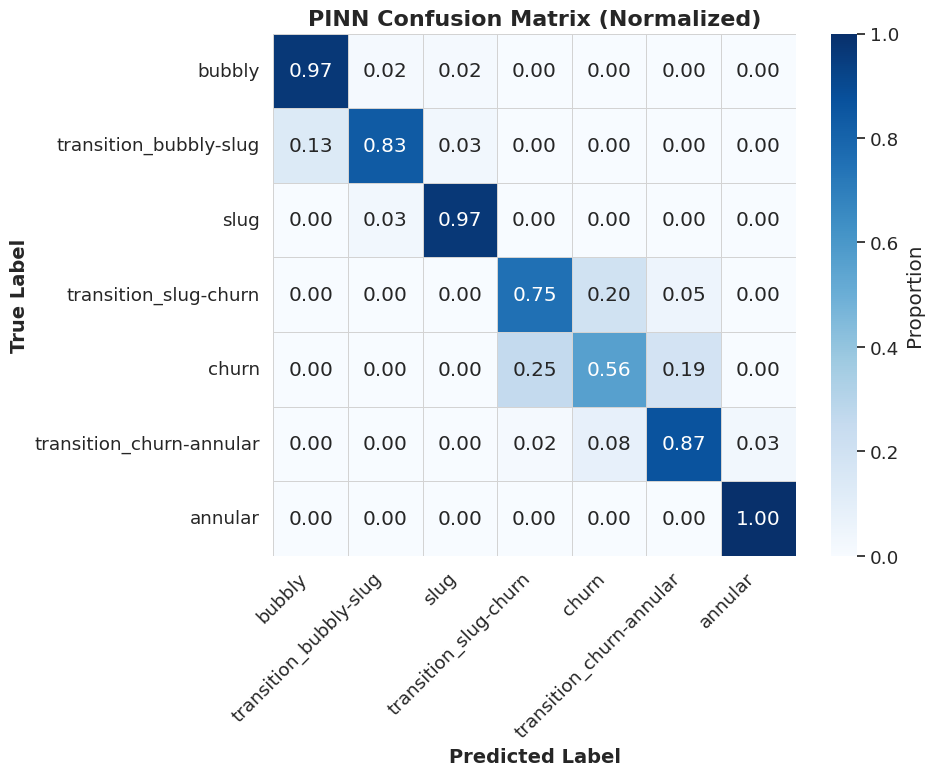

In [8]:
# Flow progression display order
flow_progression_order = [
    'bubbly',
    'transition_bubbly-slug',
    'slug',
    'transition_slug-churn',
    'churn',
    'transition_churn-annular',
    'annular'
]

display_names = flow_progression_order
permute_indices = [class_order.index(c) for c in flow_progression_order]

# Accuracy & F1
acc = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(
    y_test, y_pred_classes, labels=permute_indices, target_names=display_names))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm_reordered = cm[np.ix_(permute_indices, permute_indices)]
cm_normalized = cm_reordered.astype(float) / cm_reordered.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set(font_scale=1.2)

sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    linewidths=0.5,
    linecolor='lightgray',
    square=True,
    xticklabels=display_names,
    yticklabels=display_names,
    cbar_kws={'label': 'Proportion'}
)

plt.gca().set_facecolor('white')
plt.title('PINN Confusion Matrix (Normalized)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()

output_dir = '/content/drive/MyDrive/output'
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, 'pinn_confusion_matrix.png'), dpi=300, facecolor='white')
plt.show()

## ROC Curve and AUC

class_preds_ordered shape: (415, 7)
y_test_bin_ordered shape: (415, 7)
Macro-average AUC: 0.9835


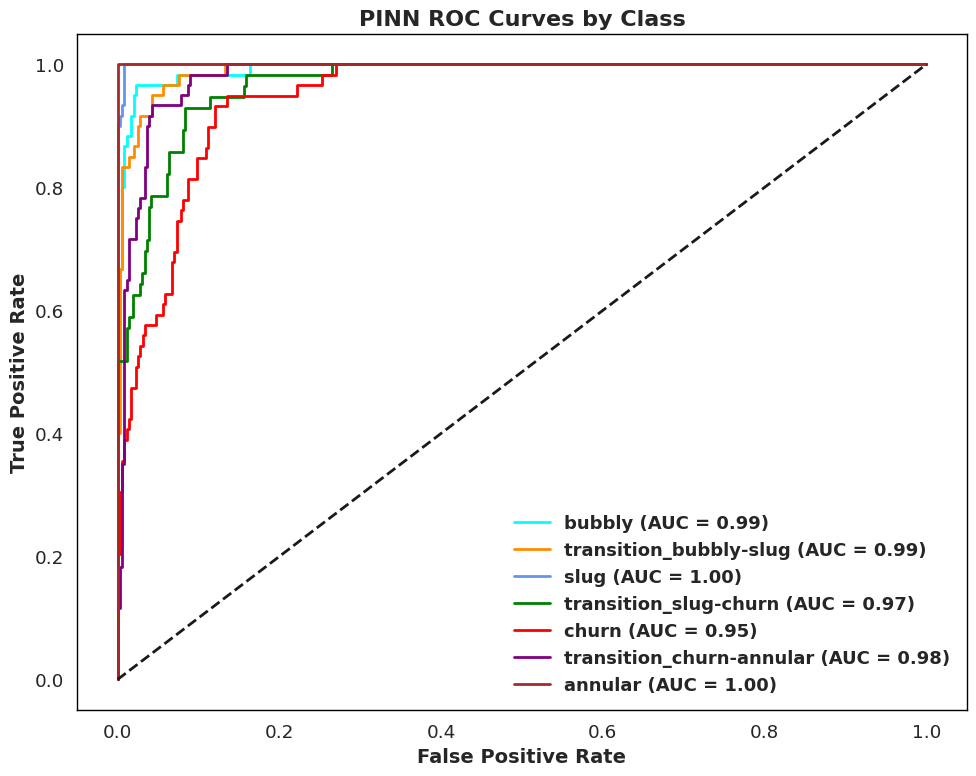

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

permute_indices = [class_order.index(c) for c in flow_progression_order]
class_preds_ordered = y_pred_probs[:, permute_indices]
y_test_bin = label_binarize(y_test, classes=list(range(len(class_order))))
y_test_bin_ordered = y_test_bin[:, permute_indices]
n_classes = len(flow_progression_order)

print("class_preds_ordered shape:", class_preds_ordered.shape)
print("y_test_bin_ordered shape:", y_test_bin_ordered.shape)

# Compute ROC and AUC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_ordered[:, i], class_preds_ordered[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_auc = np.mean(list(roc_auc.values()))
print(f"Macro-average AUC: {macro_auc:.4f}")

# Plot ROC curves
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown'])

for i, color in zip(range(n_classes), colors):
    ax.plot(
        fpr[i], tpr[i], color=color, lw=2,
        label=f"{flow_progression_order[i]} (AUC = {roc_auc[i]:.2f})"
    )

ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax.set_title('PINN ROC Curves by Class', fontsize=16, fontweight='bold')

legend = ax.legend(loc="lower right", fontsize=13, frameon=False)
for text in legend.get_texts():
    text.set_fontweight('bold')

ax.grid(False)
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

plt.tight_layout()

plt.savefig(os.path.join(output_dir, 'pinn_roc_curves_flow_order.png'), dpi=300, facecolor='white')
plt.show()

# Example Predictions per Class

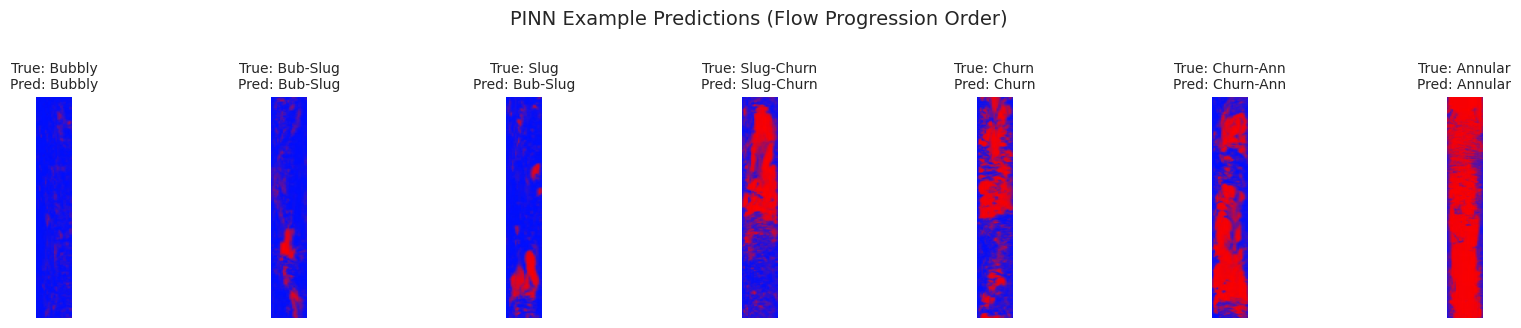

In [20]:
# Map class names to IDs
name_to_id = {class_order[i]: i for i in range(len(class_order))}

fig, axes = plt.subplots(1, len(flow_progression_order), figsize=(18, 3))

for i, class_name in enumerate(flow_progression_order):
    class_id = name_to_id[class_name]
    idx = np.where(y_test == class_id)[0][0]
    img_path = images_path[idx]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    true_label = display_labels[class_order[y_test[idx]]]
    pred_label = display_labels[class_order[y_pred_classes[idx]]]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('PINN Example Predictions (Flow Progression Order)', fontsize=14, y=1.1)
plt.savefig(os.path.join(output_dir, 'pinn_example_predictions_progression.png'),
            dpi=300, bbox_inches='tight')
plt.show()

# Grad-CAM Visualization

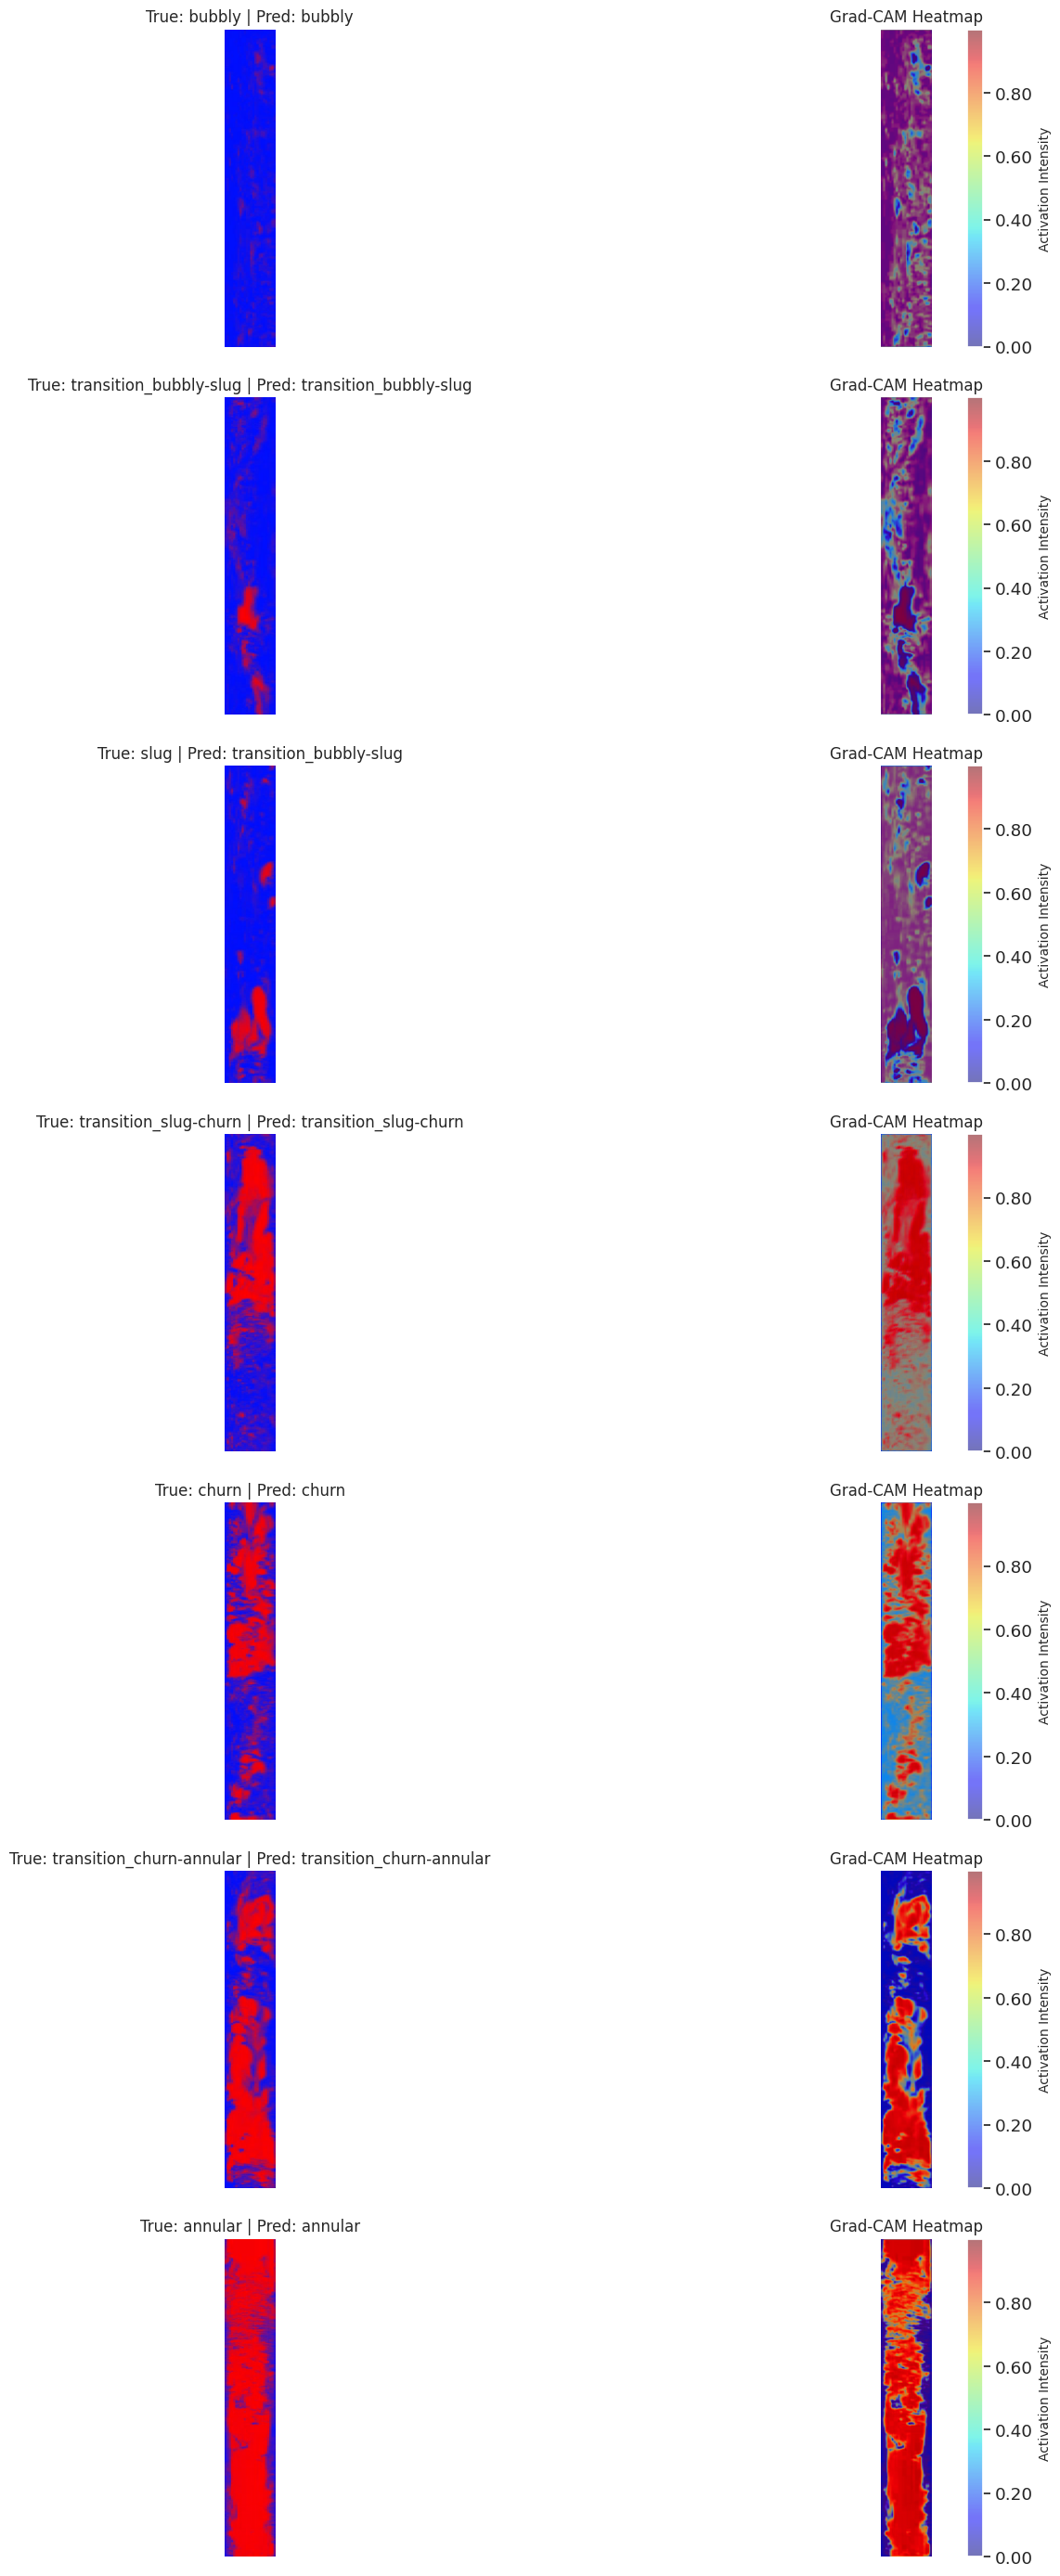

In [19]:
# Map class names to IDs
name_to_id = {class_order[i]: i for i in range(len(class_order))}

# Initialize Grad-CAM
target_layer = model.conv1
gradcam = GradCAM(model, target_layer)

# Collect one sample per class following the progression order
sample_by_class = {}
for img, label in test_dataset:
    class_id = label.item()
    class_name = class_order[class_id]
    if class_name not in sample_by_class and class_name in flow_progression_order:
        sample_by_class[class_name] = img.unsqueeze(0).to(device)
    if len(sample_by_class) == len(flow_progression_order):
        break

# Plot Grad-CAM heatmaps
plt.figure(figsize=(14, 4 * len(flow_progression_order)))
for i, class_name in enumerate(flow_progression_order):
    class_id = name_to_id[class_name]
    img_tensor = sample_by_class[class_name]
    heatmap = gradcam.generate(img_tensor, class_id)

    img_np = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    img_np = np.clip((img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8), 0, 1)

    with torch.no_grad():
        output = model(img_tensor)
        if isinstance(output, tuple):
            output = output[0]
        pred_id = torch.argmax(output, dim=1).item()

    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    overlay = np.clip(0.5 * heatmap_colored + 0.5 * img_np, 0, 1)

    plt.subplot(len(flow_progression_order), 2, 2 * i + 1)
    plt.imshow(img_np)
    plt.title(f"True: {class_name} | Pred: {class_order[pred_id]}", fontsize=12)
    plt.axis("off")

    plt.subplot(len(flow_progression_order), 2, 2 * i + 2)
    plt.imshow(img_np)
    im = plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap", fontsize=12)
    plt.axis("off")
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('Activation Intensity', fontsize=10)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}'))

plt.tight_layout()
plt.show()
gradcam.remove_hooks()